# Session 2 - Multi-Armed Bandits - Assignment

In this assignment you will apply different types of multi-armed bandits (MAB's) in order to discover the bandit giving you the highest reward.
We will start with a deterministic bandits, meaning that the bandit rewards are fixed and not subject to any underlying stochastic process.
Next we will focuss on stochastic bandits. Here the reward of a bandit is the result of a stochastic process. 
Finally we will applay the MAB strategies to solve practical real-life problems.

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})

## 1. Deterministic bandits
Assume you have to play 5 bandits with fixed rewards. These rewards are hidden and unknown when you start playing. 
You can play the bandits 100 times. Find out how you can maximize your total reward over these 100 trials.

Use the BanditEnv_1 environment for this experiment.

In [2]:
##### Deterministic Bandit Environment

class BanditEnv_1:
    def __init__(self):
        self.rewards = [-10,6,8,0,-2]

    def step(self,action):
        self.action = action
        return self.rewards[self.action]

In [3]:
# Create an Env1 object
Env1 = BanditEnv_1()

In [12]:
# Taken an action. For example choose bandit 0
reward = Env1.step(0)
print('reward =', reward)

reward = -10


If you know in advance that the bandits have fixed rewards, the best strategy will be to play them all once and then pick the one with the highest reward (greedy action).

[-10, 6, 8, 0, -2]
Bandit with the highest reward is bandit 2 with a reward of 8
The total reward =  760


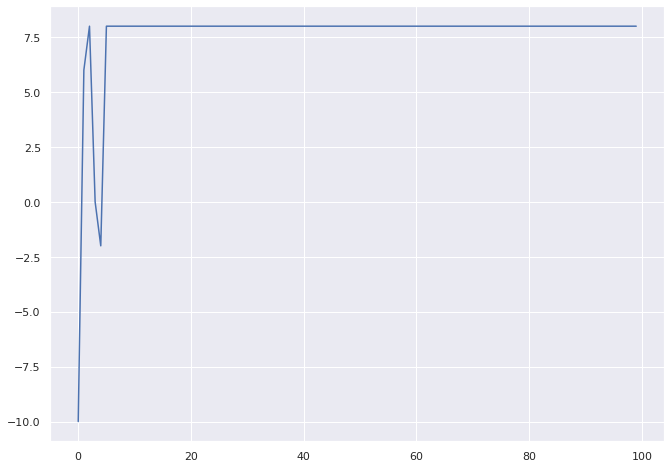

In [5]:
rewards = []
totalReward = 0
for step_action in range(5):
    rewards.append(Env1.step(step_action))

print(rewards)
bestAction = np.argmax(rewards)
print('Bandit with the highest reward is bandit',bestAction, 'with a reward of',rewards[bestAction])

for i in range(100 - 5):
    rewards.append(Env1.step(bestAction))
    totalReward = totalReward + Env1.step(bestAction)

print('The total reward = ', totalReward)

# Plot the rewards as a funtion of the number of trials
plt.plot(rewards)

##### 2. Stochastic bandits

In the case of stochastic bandits, the reward is sampled from an initially unknown distribution. Our task is to discover the expected reward of each of the bandits as quickly (and reliably) as possible. 
Image the rewards of bandit come from a normal distribution with mean = 10 and standard deviation of 5. This means that in 68% procent of the trials this bandit will return a reward between 10-5 = 5 and 10+5 = 15. If you play this bandit multiple times, you can expect that the average reward will converge to 10.

Use BanditEnv_2 for this exercise. All 5 bandits have rewards coming from normal distributions with different means, but with the same standard deviation (std = 1).
You can play this bandit 200 times. Try to come up with a good strategy to maximize the total reward over these 200 trials.

In [3]:
class BanditEnv_2:
    def __init__(self, std = 1):
        self.means = [-10,6,8,0,-2]
        self.std = std

    def step(self,action):
        return np.random.normal(self.means[action], self.std, 1)[0]

In [4]:
# Create an Env2 object
Env2 = BanditEnv_2()

In [5]:
class BaseAgent:
    def __init__(self, bandit, initializer = np.zeros, iters = 100, action_func = np.argmax):
        self.bandit = bandit
        self.mean_reward = 0
        self.total_step_count = 0
        self.iters = iters
        self.k_rewards = initializer(len(bandit.means)) # avg reward for each action
        self.rewards = np.ones(iters)
        self.step_count = np.zeros(len(bandit.means))
        self.action_func = action_func

    @property
    def best_action(self):
        return np.argmax(self.k_rewards)

    def _explore(self):
        return random.randint(0, len(self.bandit.means) - 1)

    def _exploit(self):
        return self.action_func(self.k_rewards)

    def _update_reward(self, action, reward):
        # Calculate mean reward per action
        self.k_rewards[action] = self.k_rewards[action] + ((reward - self.k_rewards[action]) / self.step_count[action])
        # Calculate total reward for this epoch
        self.mean_reward = self.mean_reward + ((reward - self.mean_reward) / self.total_step_count)

    def _update_step_counts(self, action):
        self.step_count[action] += 1
        self.total_step_count += 1

    def __choose_and_update_params(self):
        pass

    def run(self):
        pass

In [6]:
def rolling_average(rewards, window=3):
    averages = []
    for i in range(0, len(rewards) - window):
        moving_avg = 0
        for j in range(window):
            moving_avg += rewards[i+j]
        averages.append(moving_avg / window)
    return averages

### 2.1 Epsilon Greedy

1. Implement the epsilon greedy algorithm to play the Env2 bandits. 
2. Show the influence of epsilon parameter. Do this by plotting the reward history for different values of epsilon. Also visualize how often a bandit was chosen.
3. Find the optimal epsilon value giving you maximum total reward.
4. Use epsilon decay. This means that you gradually decrease the value of epsilon as the number of trials increases. Use the following rule: $\epsilon(t+1) = \eta \times \epsilon(t) $ where $0< \eta < 1$
5. Now test for different values of the standard deviation. What if the standard deviation becomes larger?

In [6]:
class EpsilonGreedyAgent(BaseAgent):
    def __init__(self, epsilon=0.1, decay = 1.0, *args, **kwargs):
        BaseAgent.__init__(self, *args, **kwargs)
        self.epsilon = epsilon
        self.decay = decay
        self.starting_epsilon = epsilon
        self.name= 'EG'

    def __choose_and_update_params(self):
        action = self._explore() if self.epsilon > random.random() else self._exploit()
        reward = self.bandit.step(action)

        self._update_step_counts(action)
        self._update_reward(action, reward)
        self.epsilon = self.epsilon * self.decay

    def run(self):
        for i in range(self.iters):
            self.__choose_and_update_params()
            self.rewards[i] = self.mean_reward
    
    def __str__(self):
        return f'Epsilon Greedy, E={self.starting_epsilon}, decay={self.decay}'

In [38]:
# 2. Influence epsilon parameter
agents = [EpsilonGreedyAgent(Env2, epsilon=0.1, iters=2000), EpsilonGreedyAgent(Env2, epsilon=0.01, iters=2000), EpsilonGreedyAgent(Env2, epsilon=0.4, iters=2000), EpsilonGreedyAgent(Env2, epsilon=0.7, iters=2000), EpsilonGreedyAgent(Env2,epsilon= 0.95, iters=2000)]
for agent in agents:
    agent.run()

&lt;matplotlib.legend.Legend at 0x7f7a93b99f40&gt;

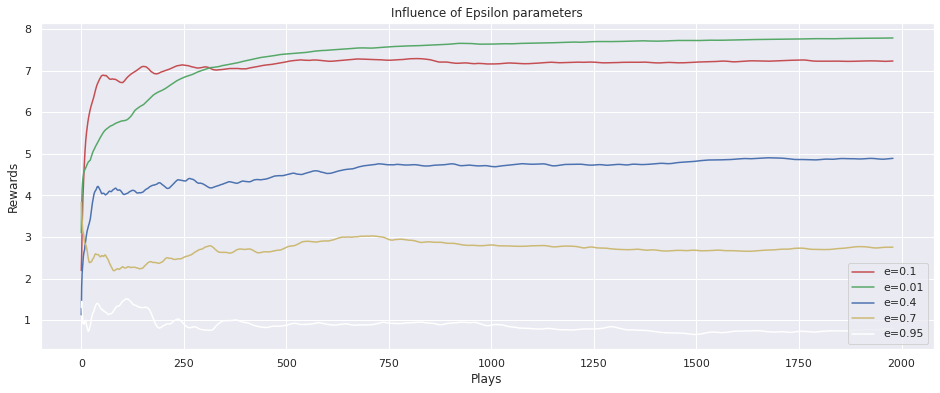

In [39]:
colors = 'rgbyw'
fig = plt.figure(figsize=(16, 6))
for i, agent in enumerate(agents):
    plt.plot(rolling_average(agent.rewards, 20), f'{colors[i]}-', label=f'e={agent.epsilon}', figure=fig)

plt.xlabel('Plays')
plt.ylabel('Rewards')
plt.title('Influence of Epsilon parameters')
plt.legend(loc='lower right')

Averge action reward: [-9.52092988  6.08893887  0.          0.         -1.58752691]
Best action: 1


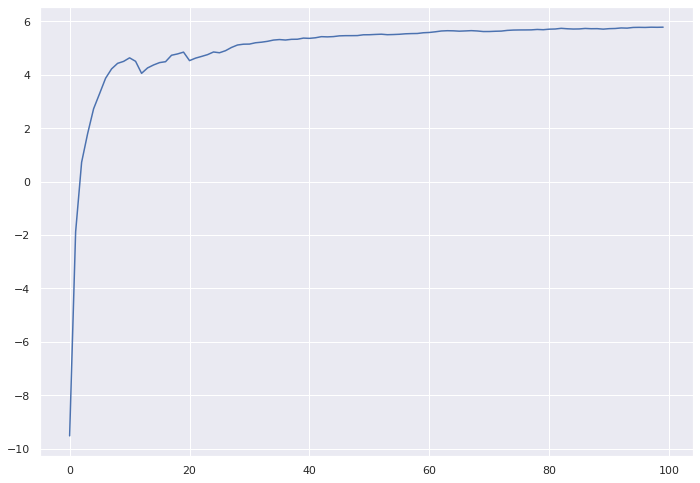

In [41]:
# 4. Epsilon decay
agent_decay = EpsilonGreedyAgent(Env2, decay=0.9)
agent_decay.run()

plt.plot(agent_decay.rewards)
print('Averge action reward:', agent_decay.k_rewards)
print('Best action:', agent_decay.best_action)

Averge action reward: [-8.17616021  6.02981321  8.00846079 -2.14566901  3.04674173]
Best action: 2


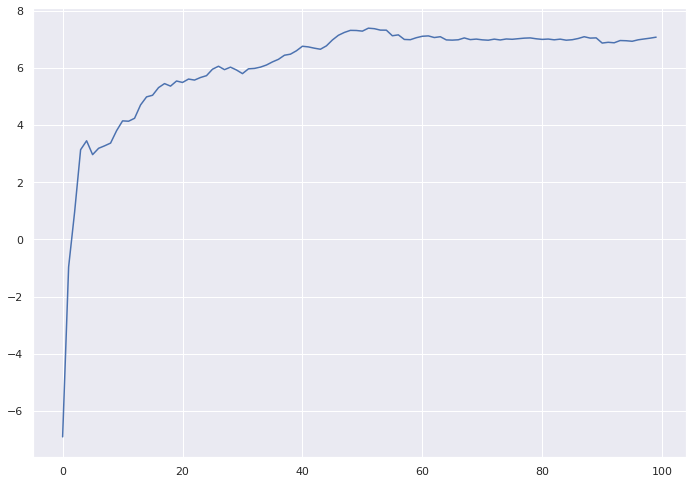

In [42]:
Env2Std = BanditEnv_2(std=3)
agent_std = EpsilonGreedyAgent(Env2Std)
agent_std.run()

plt.plot(agent_std.rewards)
print('Averge action reward:', agent_std.k_rewards)
print('Best action:', agent_std.best_action)

### 2.2 Optimistic Initial Value

Continue to work with the Env2 environment. 
Implement the Optimistic Initial Value algorithm. Start by initializing the estimated bandit means to a high non-zero value and use a greedy approach. 
After each play the estimated bandit mean will come closer to the true bandit mean.

1. Implement the optimistic initial value algorithm to play the Env2 bandits. Check the final values of the estimated means.
2. Show the initialization. What happens if you initialize the estimated means to larger values? 
3. Now test for different values of the standard deviation. What if the standard deviation becomes larger?
4. Compare the optimistic initial value approach to the epsilon greedy approach. Plot the reward history of both in one graph.



In [7]:
def optimistic_initializer(num_actions):
    return [100 for _ in range(num_actions)]

# Optimistic initial value
class OIVAgent(EpsilonGreedyAgent):
    def __init__(self, epsilon=0, *args, **kwargs):
        EpsilonGreedyAgent.__init__(self, *args, **kwargs, epsilon=epsilon)
        self.name = 'OIV'
    
    def __str__(self):
        return f'OIV E={self.epsilon}'


Averge action reward: [-9.318848228826411, 6.064903073135355, 8.122901143706372, -1.1952994110660597, -2.517951016280236]
Best action: 2


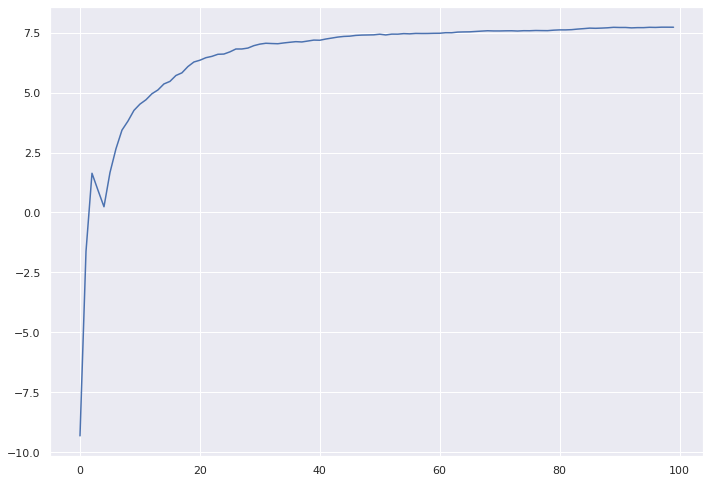

In [47]:
oiv_agent = OIVAgent(Env2)
oiv_agent.run()

plt.plot(oiv_agent.rewards)
print('Averge action reward:', oiv_agent.k_rewards)
print('Best action:', oiv_agent.best_action)

Text(0, 0.5, &#39;Reward&#39;)

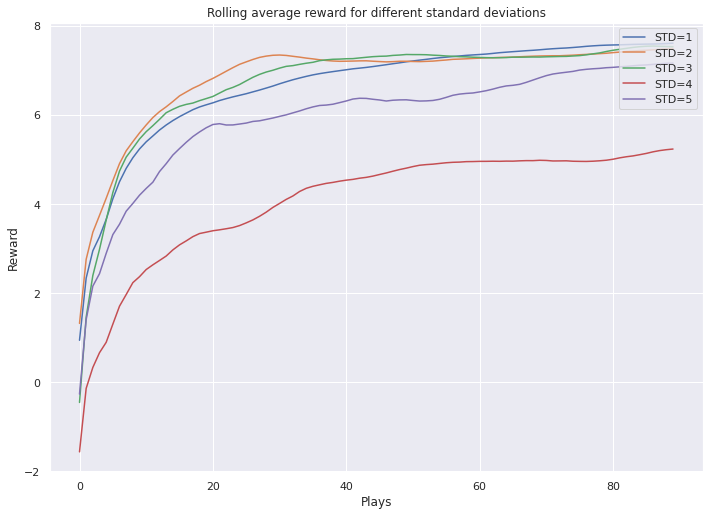

In [48]:
# 2 Bigger std
for i in range(1, 6):
    env = BanditEnv_2(i)
    agent = OIVAgent(env)
    agent.run()
    plt.plot(rolling_average(agent.rewards, 10), label='STD={}'.format(i))

plt.legend(loc='upper right')
plt.title('Rolling average reward for different standard deviations')
plt.xlabel('Plays')
plt.ylabel('Reward')

In [57]:
# 3 Epsilon / Optimistic comparison
epsilon_agent = EpsilonGreedyAgent(Env2, zero_initializer, decay=0.9, iters=2000)
oiv_agent = OIVAgent(Env2, iters=2000)

epsilon_agent.run()
oiv_agent.run()

Text(0, 0.5, &#39;Reward&#39;)

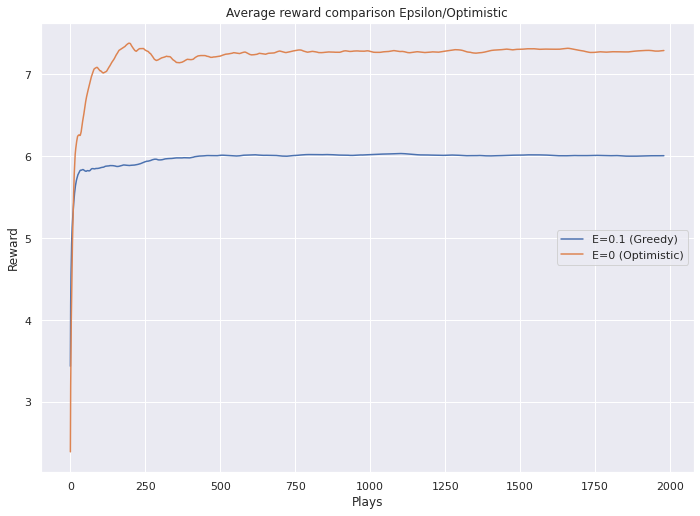

In [59]:
plt.plot(rolling_average(epsilon_agent.rewards, 20), label="E=0.1 (Greedy)")
plt.plot(rolling_average(oiv_agent.rewards, 20), label='E=0 (Optimistic)')

plt.legend(loc='center right')
plt.title('Average reward comparison Epsilon/Optimistic')
plt.xlabel('Plays')
plt.ylabel('Reward')

## Upper Confidence Bound

Continue to work with the Env2 environment and implement the Upper Confidence Bound algorithm. 
Select the action based on the following rule:

$A_t = argmax_a \left( MeanRewards + c  \sqrt{\frac{\ln{t}}{N_a(t)}}  \right)$

1. Implement the upper confidence bound algorithm to play the Env2 bandits. Check the final values of the estimated means.
2. Change the parameter c? Explain the influence of c. 
3. Now test for different values of the standard deviation. What if the standard deviation becomes larger?
4. Compare the upper confidence bound approach to the epsilon greedy approach and opimistic initial value. Plot the reward histories of the algorithms in one graph.


In [8]:
# Upper Confidence Bound
class UCBAgent(BaseAgent):
    def __init__(self, c = 2, **kwargs):
        BaseAgent.__init__(self, **kwargs)
        self.c = c
        self.step_count = np.ones(len(kwargs['bandit'].means))
        self.name='UCB'

    def __choose_and_update_params(self):
        action = self.action_func(self.k_rewards + self.c * np.sqrt(np.log(self.total_step_count) / self.step_count))
        reward = self.bandit.step(action)
        self.total_step_count += 1
        self.step_count[action] += 1

        self._update_reward(action, reward)

    def __initialize_bandits(self):
        for i in range(len(self.bandit.means)):
            self.k_rewards[i] = self.bandit.step(i)

    def run(self):
        self.__initialize_bandits()
        for i in range(self.iters):
            self.__choose_and_update_params()
            self.rewards[i] = self.mean_reward
    
    def __str__(self):
        return f'UCB, C={self.c}'

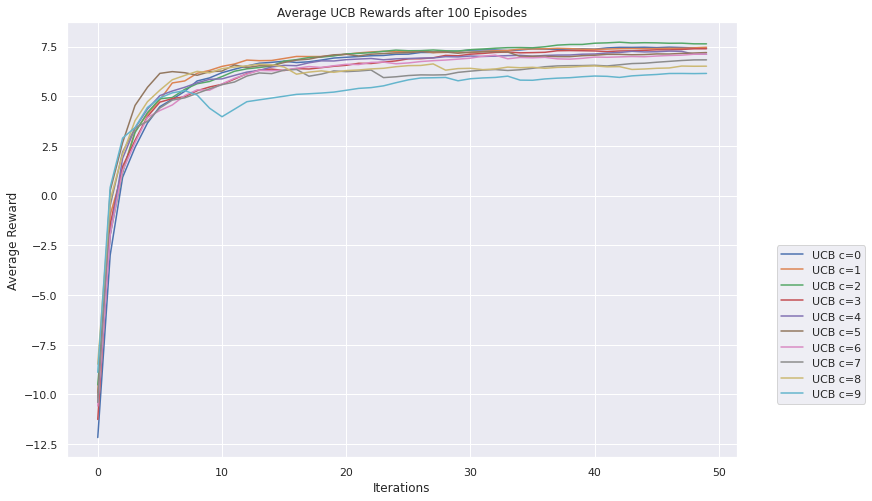

In [90]:
episodes = 100

plt.figure(figsize=(12,8))
plt.xlabel("Iterations")
plt.ylabel("Average Reward")
plt.title("Average UCB Rewards after " 
          + str(episodes) + " Episodes")

for i in range(10):
    ucb_agent = UCBAgent(c=i, bandit=Env2, iters=50)
    ucb_agent.run()
    plt.plot(ucb_agent.rewards, label=f'UCB c={i}')
    del ucb_agent   

plt.legend(bbox_to_anchor=(1.2, 0.5))
plt.show()

## 3. Server latencies

There are 25 servers to choose from to make 1000 different webpage requests. Your task is to come up with a clever way to select the server with the lowest latency.
The file 'latencies.csv' contains these 1000 different request. 
It's important to know that in a practical situation you would not have access to this data and requests will be made sequentially.
Use a multi-armed bandit to find the best strategy to minimize the total latency over these 1000 requests. Again, it's not allowed to process and statistically analyse the data in advance.

1. Try and optimize different types of bandits: epsilon-greedy, optimistic initial value, upper confidence bound. 
2. Compare these bandits in terms of total cumulated reward (or regret). Make a graph to visualize this.
3. Make graphs showing how often each bandit was chosen.


EXTRA: program a bayesian badit to solve the latency problem.

In [9]:
dataset = pd.read_csv('latencies.csv')
dataset.tail()

,Server_1,Server_2,Server_3,Server_4,Server_5,Server_6,Server_7,Server_8,Server_9,Server_10,...,Server_16,Server_17,Server_18,Server_19,Server_20,Server_21,Server_22,Server_23,Server_24,Server_25
995,265,1080,136,25,395,1350,105,113,85,471,...,414,129,410,176,589,92,56,1298,234,2603
996,473,6306,84,121,392,33,103,97,876,883,...,451,129,412,245,1113,132,62,11429,305,2264
997,269,1064,83,25,399,33,104,99,615,639,...,417,132,561,143,652,101,56,953,232,2293
998,270,1071,84,24,393,33,120,118,298,755,...,415,129,327,871,670,109,60,954,232,2251
999,296,1065,84,25,395,34,104,111,83,751,...,413,130,305,122,763,102,74,1640,352,2530


In [ ]:
# Server latencies
class ServerBandit:
    def __init__(self, data):
        self.data = data
        self.means = data.columns
        self.step_count = -1

    @property
    def n_actions(self):
        return len(self.means)

    def step(self, action_index):
        self.step_count += 1
        if self.step_count >= len(self.data) - 1:
            pass
        elif self.step_count >= len(self.data) + 10:
            raise KeyError(self.step_count)
        return self.data.loc[self.step_count][self.means[action_index]]
    
    def reset(self):
        self.step_count = -1


In [ ]:
server_env = ServerBandit(dataset)
episodes = len(dataset)
action_count = []

agents = [EpsilonGreedyAgent(bandit=server_env, epsilon=0.3, decay=0.99, iters=episodes, action_func=np.argmin), OIVAgent(bandit=server_env, action_func=np.argmin, iters=episodes), UCBAgent(bandit=server_env, action_func=np.argmin, iters=episodes - server_env.n_actions)]

fig, (ax1, ax2) = plt.subplots(ncols=2)
fig.set_figwidth(30)

for i, agent in enumerate(agents):
    agent.run()
    for i, server in enumerate(server_env.means):
        action_count.append({
            'server': server,
            'agent': agent.name,
            'count': agent.step_count[i]
        })
    action_count[i]['count'] = agent.step_count
    ax1.plot(agent.rewards, label=agent)
    server_env.reset()

ax1.legend(loc='upper right')
ax1.set_title('Average latency per bandit')
ax1.set_xlabel('Requests')
ax1.set_ylabel('Latency')

action_count_df = pd.DataFrame(data=action_count)
action_count_df = action_count_df.explode('count')
ax2.set_title('Server picks per bandit')
sns.barplot(data=action_count_df, x='server', y='count', hue='agent')
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=40, ha="right")
plt.show()

In [10]:
server_env = ServerBandit(dataset)
episodes = len(dataset)
action_count = []

agents = [EpsilonGreedyAgent(bandit=server_env, epsilon=0.3, decay=0.99, iters=episodes, action_func=np.argmin), OIVAgent(bandit=server_env, action_func=np.argmin, iters=episodes), UCBAgent(bandit=server_env, action_func=np.argmin, iters=episodes - server_env.n_actions)]

fig, (ax1, ax2) = plt.subplots(ncols=2)
fig.set_figwidth(30)

for i, agent in enumerate(agents):
    agent.run()
    for i, server in enumerate(server_env.means):
        action_count.append({
            'server': server,
            'agent': agent.name,
            'count': agent.step_count[i]
        })
    action_count[i]['count'] = agent.step_count
    ax1.plot(agent.rewards, label=agent)
    server_env.reset()

ax1.legend(loc='upper right')
ax1.set_title('Average latency per bandit')
ax1.set_xlabel('Requests')
ax1.set_ylabel('Latency')

action_count_df = pd.DataFrame(data=action_count)
action_count_df = action_count_df.explode('count')
ax2.set_title('Server picks per bandit')
sns.barplot(data=action_count_df, x='server', y='count', hue='agent')
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=40, ha="right")
plt.show()

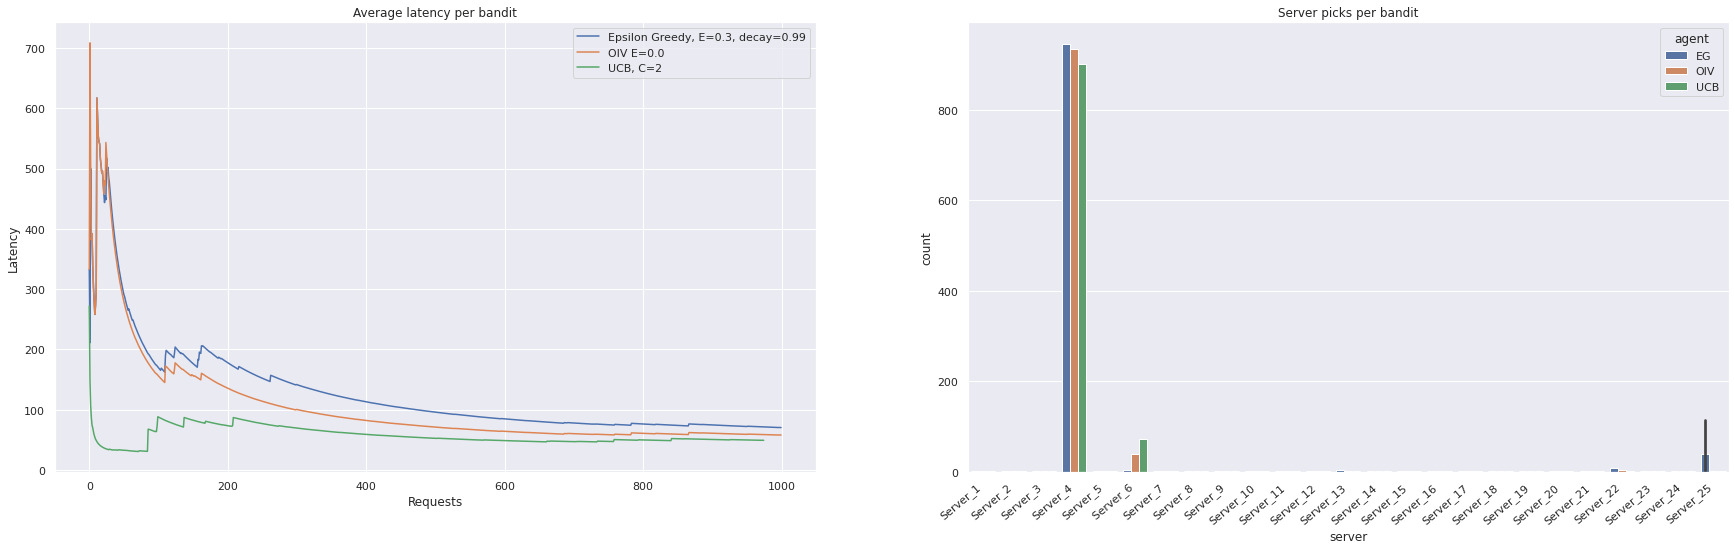

In [23]:
server_env = ServerBandit(dataset)
episodes = len(dataset)
action_count = []

agents = [EpsilonGreedyAgent(bandit=server_env, epsilon=0.3, decay=0.99, iters=episodes, action_func=np.argmin), OIVAgent(bandit=server_env, action_func=np.argmin, iters=episodes), UCBAgent(bandit=server_env, action_func=np.argmin, iters=episodes - server_env.n_actions)]

fig, (ax1, ax2) = plt.subplots(ncols=2)
fig.set_figwidth(30)

for i, agent in enumerate(agents):
    agent.run()
    for i, server in enumerate(server_env.means):
        action_count.append({
            'server': server,
            'agent': agent.name,
            'count': agent.step_count[i]
        })
    action_count[i]['count'] = agent.step_count
    ax1.plot(agent.rewards, label=agent)
    server_env.reset()

ax1.legend(loc='upper right')
ax1.set_title('Average latency per bandit')
ax1.set_xlabel('Requests')
ax1.set_ylabel('Latency')

action_count_df = pd.DataFrame(data=action_count)
action_count_df = action_count_df.explode('count')
ax2.set_title('Server picks per bandit')
sns.barplot(data=action_count_df, x='server', y='count', hue='agent')
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=40, ha="right")
plt.show()